# Getting started with Task 2

Instructions:
- Download the dataset from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
- Unzip the `archive.zip` file
- Rename the folder `archive` as `ecg_dataset` and place it in the root of the git repository

References:
- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

## Load dependencies

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## MIT-BIH  Arrhythmia Dataset

- Number of Samples: 109446
- Number of Categories: 5
- Sampling Frequency: 125Hz
- Data Source: Physionet's MIT-BIH Arrhythmia Dataset
- Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.


The shape of the mitbih_train is :  (87554, 188)
The shape of the mitbih_test is :  (21892, 188)
The last time value is :  1488.0


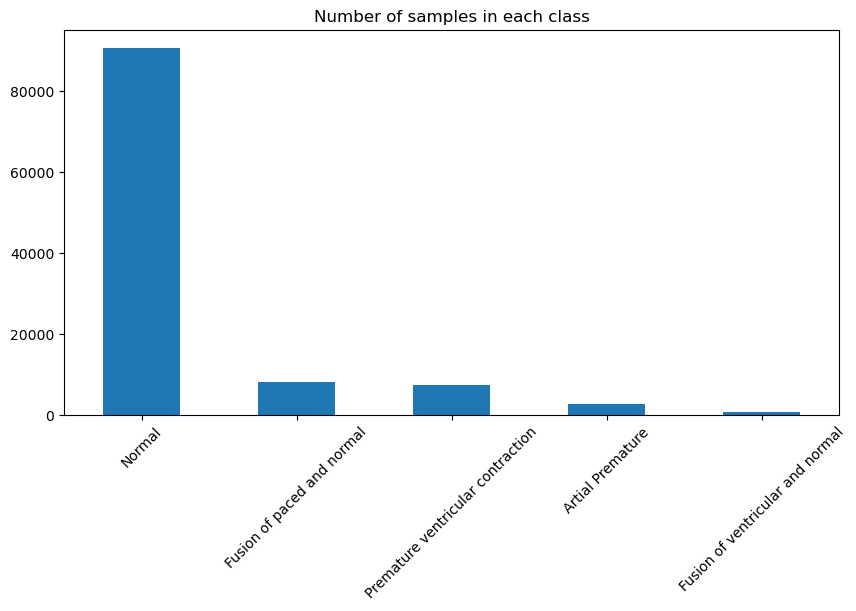

In [5]:
df_mitbih_train = pd.read_csv("../ecg_dataset/mitbih_train.csv", header = None)
df_mitbih_test = pd.read_csv("../ecg_dataset/mitbih_test.csv", header = None)

# print shapes of the dataframes
print("The shape of the mitbih_train is : ", df_mitbih_train.shape)
print("The shape of the mitbih_test is : ", df_mitbih_test.shape)

df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
#df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_mitbih.shape[1] - 1 
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_mitbih.columns = list(time) + ["label"]

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_mitbih["label"].value_counts()
# substitute the class names
counts.index = counts.index.map(id_to_label)
# create a figure 
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 45)
plt.title("Number of samples in each class")
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#0 = normal, 1 = fusion of placed and normal, 2 = premature ventricular contraction, 
#3 = artial premature 4 = fusion of ventricular and normal

df_mitbih
x = df_mitbih.loc[:, df_mitbih.columns != "label"]
y = df_mitbih.loc[:, df_mitbih.columns == "label"]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, shuffle = True)


In [7]:
import torch

x_train, x_test = torch.tensor(x_train.values, dtype = torch.float32),torch.tensor(x_test.values, dtype = torch.float32)
y_train, y_test = torch.tensor(y_train.values, dtype = torch.float32),torch.tensor(y_test.values, dtype = torch.float32)


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class LogisticRegression(nn.Module):

    def __init__(self, x, y):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(x, 64)
        self.bn1 = nn.BatchNorm1d(64)  
        self.linear2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)  
        self.linear3 = nn.Linear(32, y)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.sigmoid(self.bn1(self.linear1(x)))
        x = torch.sigmoid(self.bn2(self.linear2(x)))
        outputs = F.log_softmax(self.linear3(x))
        return outputs

In [9]:
epochs = 32
input_dim = 187
output_dim = 5
learning_rate = 0.01
train_loss_tens = torch.empty(epochs)

model = LogisticRegression(input_dim, output_dim)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)


In [ ]:
for epoch in range(epochs):
    
    print(epoch)
    count_train_loss = 0.0
    
    optimizer.zero_grad()
    pred_y = model(x_train)
    print(pred_y)

    # Compute and print loss
    train_loss = F.nll_loss(pred_y, y_train.squeeze(1).type(torch.LongTensor), size_average=False)
    print(train_loss)
    train_loss.backward()
    optimizer.step()
    #count_train_loss+= train_loss.item() 

0
tensor([[-1.6426, -1.4458, -1.6470, -1.6459, -1.6847],
        [-1.6024, -1.4329, -1.7031, -1.8591, -1.5048],
        [-1.9006, -1.5104, -1.5273, -1.8329, -1.3758],
        ...,
        [-1.7348, -1.6336, -1.7773, -1.7927, -1.2285],
        [-1.8148, -1.7099, -1.6227, -1.6240, -1.3402],
        [-1.7962, -1.5108, -1.4430, -1.9770, -1.4328]],
       grad_fn=<LogSoftmaxBackward0>)
tensor(132463.3594, grad_fn=<NllLossBackward0>)


/var/folders/6p/x21r5nb96gb8335sy4nlvy_w0000gn/T/ipykernel_14767/3061554479.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.log_softmax(self.linear3(x))
/Users/paimongoulart/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
plt.plot(train_loss_arr, 'g')

In [ ]:
with torch.no_grad():
    prediction = model(x_test)
    pred_max = prediction.data.max(1, keepdim = True)[1]
    correct = (pred_max == y_test)
    accuracy = correct.sum()/len(correct) *100

In [ ]:
y_test

In [ ]:
pred = model1(x_test)
pred_max = pred.data.max(1, keepdim = True)[1]
pred_list.append(pred_max.numpy())
y_test_list.append(y_test.numpy())
correct = (pred == y_test)
correct_list.append(correct)
accuracy = correct.sum()/len(correct) *100
accuracy_list.append(accuracy)

In [ ]:
# create a figure
plt.figure(figsize = (20, 10))
# define colors for each class
colors = ["blue", "red", "green", "orange", "purple"]
# plot the normal sequences
for i in range(3):
    for label in id_to_label.keys():
        # sample a random sequence from that label
        df_mitbih_label = df_mitbih[df_mitbih["label"] == label].sample(1)
        # plot the sequence
        if i == 0:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], label = id_to_label[label], color = colors[label])
        else:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], color = colors[label])  
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()